# Motivation
Someone walks up to you and hands over a simple data set of x and y coordinates. You eyeball it and think, "hmm seems like we can fit a quadratic function to this". This post walks through how this can be done using gradient descent (and follows the treatment in Chapter 4 of {% cite fastbook2020 %}). 

In [1]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.torch_core import *

In [2]:
num_points = 20
x = torch.arange(0,num_points).float()
x

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [3]:
d = 0.75
e = 9.5
noise = 1 + torch.randn(num_points)*3
y =  d*(x-e)**2 + noise
y, -2*d*e, d*(e**2)

(tensor([68.6996, 53.2421, 43.1072, 35.0240, 18.7474, 20.2123,  4.7285,  7.6421,
          0.6463, -0.4163, -3.0223,  5.8641,  4.2702, 12.0058, 16.8083, 20.2149,
         32.4927, 41.8890, 59.8105, 63.5625]),
 -14.25,
 67.6875)

Since $d(x-e)^{2} = d*(x^{2} -2ex + e^{2}) = dx^{2} - 2dex + d*e^{2}$ we expect to see the parameters $d$, $-2*d*e$ and $\approx 1+d*e^{2}$ being uncovered. The last term is because we are adding a $1$ in the noise.

The data then looks like the following

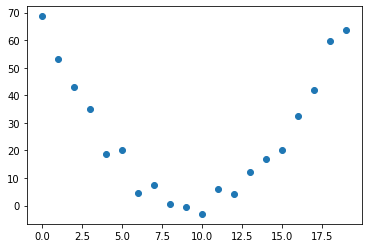

In [4]:
plt.scatter(x,y)

# Recipe
## Initialize the parameters
We need three parameters to describe a quadratic $ax^{2}+bx +c$

In [5]:
params = torch.randn(3).requires_grad_()

## Calculate the predictions
We create a function where we can plug in our input features ($x$ coordinate values in this case) and get a prediction for the $y$. The function below will do just that.

In [6]:
def f(x, params):
    a,b,c=params
    return a*(x**2) + b*x + c

The predictions, yhat, can then be obtained using

In [7]:
yhat = f(x, params)
yhat

tensor([-1.0763e-01, -9.4094e-01, -4.0345e+00, -9.3884e+00, -1.7002e+01,
        -2.6877e+01, -3.9011e+01, -5.3406e+01, -7.0062e+01, -8.8977e+01,
        -1.1015e+02, -1.3359e+02, -1.5928e+02, -1.8724e+02, -2.1746e+02,
        -2.4994e+02, -2.8467e+02, -3.2167e+02, -3.6093e+02, -4.0245e+02],
       grad_fn=<AddBackward0>)

Compare predictions to the data

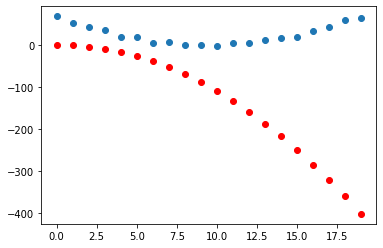

In [8]:
plt.scatter(x, y)
plt.scatter(x, to_np(yhat), color = 'red')

## Calculate the loss
We will use mean squared error for this.

In [9]:
def mse(yhat, y):
    return ((yhat-y)**2).mean()

In [10]:
loss = mse(yhat, y)
loss

tensor(44301.6484, grad_fn=<MeanBackward0>)

## Calculate the gradients

In [11]:
loss.backward()

In [12]:
params.grad

tensor([-70097.9297,  -4488.5391,   -324.2715])

## Take a gradient descent step
Set a learning rate, lr, and then do a step like so

In [13]:
lr = 1e-5
params.data -= lr*params.grad.data
params.grad = None

Get a new prediction and plot again.

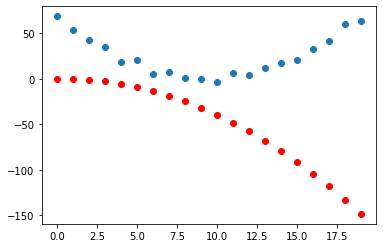

In [14]:
plt.scatter(x, y)
plt.scatter(x, to_np(f(x,params)), color = 'red')

# All together  now
Not much changed when we took a single gradient step so we will want to do this for multiple iterations. Before doing that we make a simple function, called ```step```, that will apply all of the ingredients of the recipe.

In [15]:
def step(params, lr=1e-5, prn=True):
    yhat = f(x, params)
    loss = mse(yhat, y)
    
    loss.backward()
    
    params.data -= lr*params.grad.data
    params.grad = None
    
    if prn: print(loss.item(), params)
    return yhat

And then another function that will call the ```step``` function as many times as we desire.

In [16]:
def learner(num_iterations, record_interval, lr):
    preds_list = []
    params_list = []
    for i in range(num_iterations):
        prn = i % record_interval == 0
        preds = step(params, lr, prn)
        if prn: 
            preds_list.append(preds)
            params_list.append(params.detach().clone())
    return preds_list, params_list

We will run $1,000,000$ iterations and record results every $100,000$ iterations. The first item is the loss and the second are the parameters $a,b$ and $c$ that define the quadratic we want to uncover/recover.

In [17]:
preds_list, params_list = learner(1000000, 100000, 1e-5)

8900.236328125 tensor([-0.1242,  0.3612, -0.1029], requires_grad=True)
382.91522216796875 tensor([ 0.2762, -3.2625, 15.3551], requires_grad=True)
231.8618621826172 tensor([ 0.3839, -5.7625, 27.3517], requires_grad=True)
141.83514404296875 tensor([ 0.4671, -7.6927, 36.6108], requires_grad=True)
88.12383270263672 tensor([ 0.5312, -9.1819, 43.7649], requires_grad=True)
56.144981384277344 tensor([  0.5809, -10.3335,  49.2795], requires_grad=True)
37.080955505371094 tensor([  0.6190, -11.2180,  53.5353], requires_grad=True)
25.659448623657227 tensor([  0.6487, -11.9067,  56.8358], requires_grad=True)
18.909128189086914 tensor([  0.6714, -12.4334,  59.3597], requires_grad=True)
14.805198669433594 tensor([  0.6891, -12.8450,  61.3470], requires_grad=True)


Next we plot what our best estimate of the quadratic function looked like at every $100,000$ iterations.

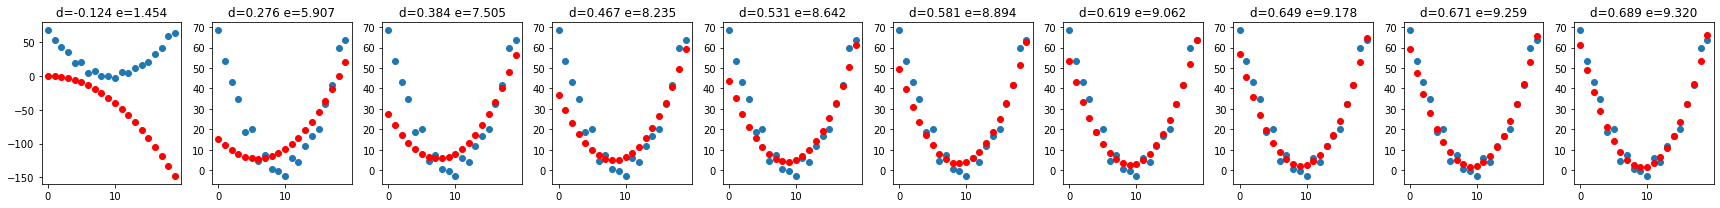

In [18]:
num_preds = len(preds_list)
_, axs = plt.subplots(1, num_preds, figsize=(24,3))
for j in range(num_preds):
    
    a,b,c = params_list[j]
    dhat = a
    ehat = -1*b/(2*a)
    
    axs[j].scatter(x, y)
    axs[j].scatter(x, to_np(preds_list[j]), color='red')
    
    axs[j].set_title(f'd={dhat:3.3f} e={ehat:3.3f}')
    
plt.tight_layout()

The captions on each plot provide an estimate of $d$ and $e$. At the end of one million iterations we have $\hat{d} = 0.689$ and $\hat{e}=9.32$. 

Recall that we generated the input data using $d=0.75$ and $e=9.5$.

# References
{% bibliography --cited %}